## 4.6 LightGBM in Machine Learning

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2021.11.11 </div>
<div style="text-align: right\"> Last update: 2021.11.11</div>

- 출처 : https://thecleverprogrammer.com/2021/01/15/lightgbm-in-machine-learning/

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

In [4]:
from matplotlib.ticker import ScalarFormatter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
from lightgbm import LGBMClassifier
import random

In [5]:
train = pd.read_csv('./data/ghouls-goblins-and-ghosts-boo/train.csv')
test = pd.read_csv('./data/ghouls-goblins-and-ghosts-boo/test.csv')

In [6]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [7]:
train.shape

(371, 7)

### Data preparation

In [8]:
train = pd.get_dummies(train, columns=['color'], prefix = ['color'])

In [9]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,type,color_black,color_blood,color_blue,color_clear,color_green,color_white
0,0,0.354512,0.350839,0.465761,0.781142,Ghoul,0,0,0,1,0,0
1,1,0.575560,0.425868,0.531401,0.439899,Goblin,0,0,0,0,1,0
2,2,0.467875,0.354330,0.811616,0.791225,Ghoul,1,0,0,0,0,0
3,4,0.776652,0.508723,0.636766,0.884464,Ghoul,1,0,0,0,0,0
4,5,0.566117,0.875862,0.418594,0.636438,Ghost,0,0,0,0,1,0


타겟 인코딩

In [11]:
train['type'].value_counts()

Ghoul     129
Goblin    125
Ghost     117
Name: type, dtype: int64

In [12]:
map = {'Ghoul': 1, 'Goblin': 2, 'Ghost': 0}

train['type'] = train['type'].map(map)

In [13]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,type,color_black,color_blood,color_blue,color_clear,color_green,color_white
0,0,0.354512,0.350839,0.465761,0.781142,1,0,0,0,1,0,0
1,1,0.575560,0.425868,0.531401,0.439899,2,0,0,0,0,1,0
2,2,0.467875,0.354330,0.811616,0.791225,1,1,0,0,0,0,0
3,4,0.776652,0.508723,0.636766,0.884464,1,1,0,0,0,0,0
4,5,0.566117,0.875862,0.418594,0.636438,0,0,0,0,0,1,0


인덱스 설정

In [15]:
train = train.set_index('id')

In [16]:
train.head()

,bone_length,rotting_flesh,hair_length,has_soul,type,color_black,color_blood,color_blue,color_clear,color_green,color_white
id,,,,,,,,,,,
0,0.354512,0.350839,0.465761,0.781142,1,0,0,0,1,0,0
1,0.575560,0.425868,0.531401,0.439899,2,0,0,0,0,1,0
2,0.467875,0.354330,0.811616,0.791225,1,1,0,0,0,0,0
4,0.776652,0.508723,0.636766,0.884464,1,1,0,0,0,0,0
5,0.566117,0.875862,0.418594,0.636438,0,0,0,0,0,1,0


데이터 분리

In [17]:
X = train.drop('type', axis =1)
y = train['type']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

### LightGBM Classifier

파라미터 구간 설정

In [20]:
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': [0.01,0.1,0.5],
    'subsample_for_bin': [20000,50000,100000,120000,150000],
    'min_child_samples': [20,50,100,200,500],
    'colsample_bytree': [0.6,0.8,1],
    "max_depth": [5,10,50,100]
}

베이스라인

In [21]:
lgbm = LGBMClassifier() # Shortname the LGBMClassifier()
lgbm.fit(X_train, y_train) # Train the lgbm on train sets

LGBMClassifier()

... 그리드 서치 해볼것..

튜닝결과

In [23]:
params = {'boosting_type' : 'gbdt',
          'class_weight': None,
          'min_child_samples' : 20,
          'num_leaves' : 30,
          'subsample_for_bin' : 20000,
          'learning_rate' : 0.01, 
          'max_depth' : 10, 
          'n_estimators' : 40, 
          'colsample_bytree': 0.6}

In [24]:
lgbm_tuned = LGBMClassifier(**params)

In [25]:
lgbm_tuned.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.6, learning_rate=0.01, max_depth=10,
               n_estimators=40, num_leaves=30, subsample_for_bin=20000)

In [26]:
y_test_pred = lgbm_tuned.predict(X_test) #Predicting X_test to find the solutiın
score = round(accuracy_score(y_test, y_test_pred), 3) # Find the accuracy of y_test and predicitons, and round the result
print(score)

0.738


feature importance

In [27]:
fi = pd.DataFrame()
fi['features'] = X.columns.values.tolist()
fi['importance'] = lgbm_tuned.feature_importances_

<AxesSubplot:xlabel='importance', ylabel='features'>

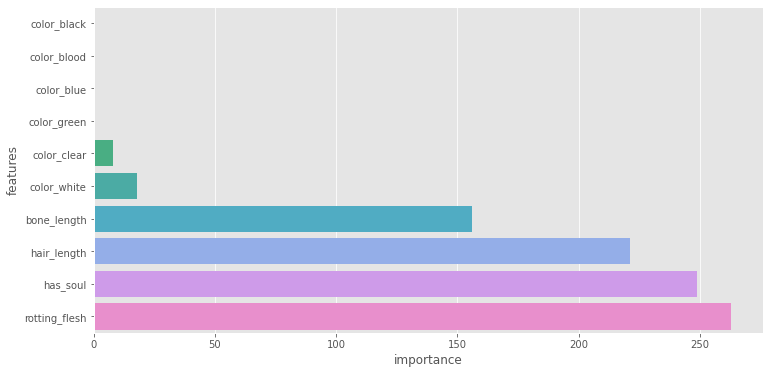

In [29]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x='importance', y='features', data=fi.sort_values(by='importance', ascending=True))